In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.utils.class_weight import compute_class_weight
import joblib
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

df = pd.read_csv("../data/cleaned_responses.csv")

print("Original dataset shape:", df.shape)
print("Target variable distribution:")
print(df['diabetes_diagnosed'].value_counts())
print(f"Diabetes prevalence: {(df['diabetes_diagnosed'].sum() / len(df)) * 100:.2f}%")


In [ ]:
# Feature selection and preparation

feature_cols = ['gender', 'pregnancies', 'age', 'glucose', 'blood_pressure', 
                'weight', 'height', 'insulin', 'bmi', 'physically_active', 
                'smoking', 'junk_food', 'family_history']

X = df[feature_cols].copy()
y = df['diabetes_diagnosed'].astype(int).copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Features used: {feature_cols}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute class weights to handle imbalance
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)


NameError: name 'df' is not defined

In [ ]:
# Build the ANN model

def build_ann(input_dim: int) -> Sequential:
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

model = build_ann(X_train_scaled.shape[1])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,969 (15.50 KB)

 Trainable params: 3,745 (14.63 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# Train the model with callbacks

EPOCHS = 200
BATCH_SIZE = 16

callbacks = [
    EarlyStopping(monitor='val_auc', mode='max', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
]

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("Training completed.")


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8500 - auc: 0.9152 - loss: 0.3732 - precision: 0.7179 - recall: 0.8750 - val_accuracy: 0.9804 - val_auc: 0.9848 - val_loss: 0.2223 - val_precision: 0.9474 - val_recall: 1.0000 - learning_rate: 1.2500e-04
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8850 - auc: 0.9503 - loss: 0.2925 - precision: 0.7662 - recall: 0.9219 - val_accuracy: 0.9804 - val_auc: 0.9857 - val_loss: 0.2157 - val_precision: 0.9474 - val_recall: 1.0000 - learning_rate: 1.2500e-04
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8350 - auc: 0.9205 - loss: 0.3622 - precision: 0.7123 - recall: 0.8125 - val_accuracy: 0.9804 - val_auc: 0.9848 - val_loss: 0.2097 - val_precision: 0.9474 - val_recall: 1.0000 - learning_rate: 1.2500e-04
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8700 - auc: 0.9588 - loss: 0.2747 - precision: 0.7500 - recall: 0.8906 - val_accuracy: 0.9804 - val_auc: 0.9857 - val_loss: 0.20

In [ ]:
# Evaluate on test set

y_pred_proba = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("\nANN Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

ANN Model Performance Metrics:
Accuracy: 0.9206
Precision: 0.8333
Recall: 0.9524
F1-Score: 0.8889
AUC-ROC: 0.9694

Confusion Matrix:
[[38  4]
 [ 1 20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.83      0.95      0.89        21

    accuracy                           0.92        63
   macro avg       0.90      0.93      0.91        63
weighted avg       0.93      0.92      0.92        63



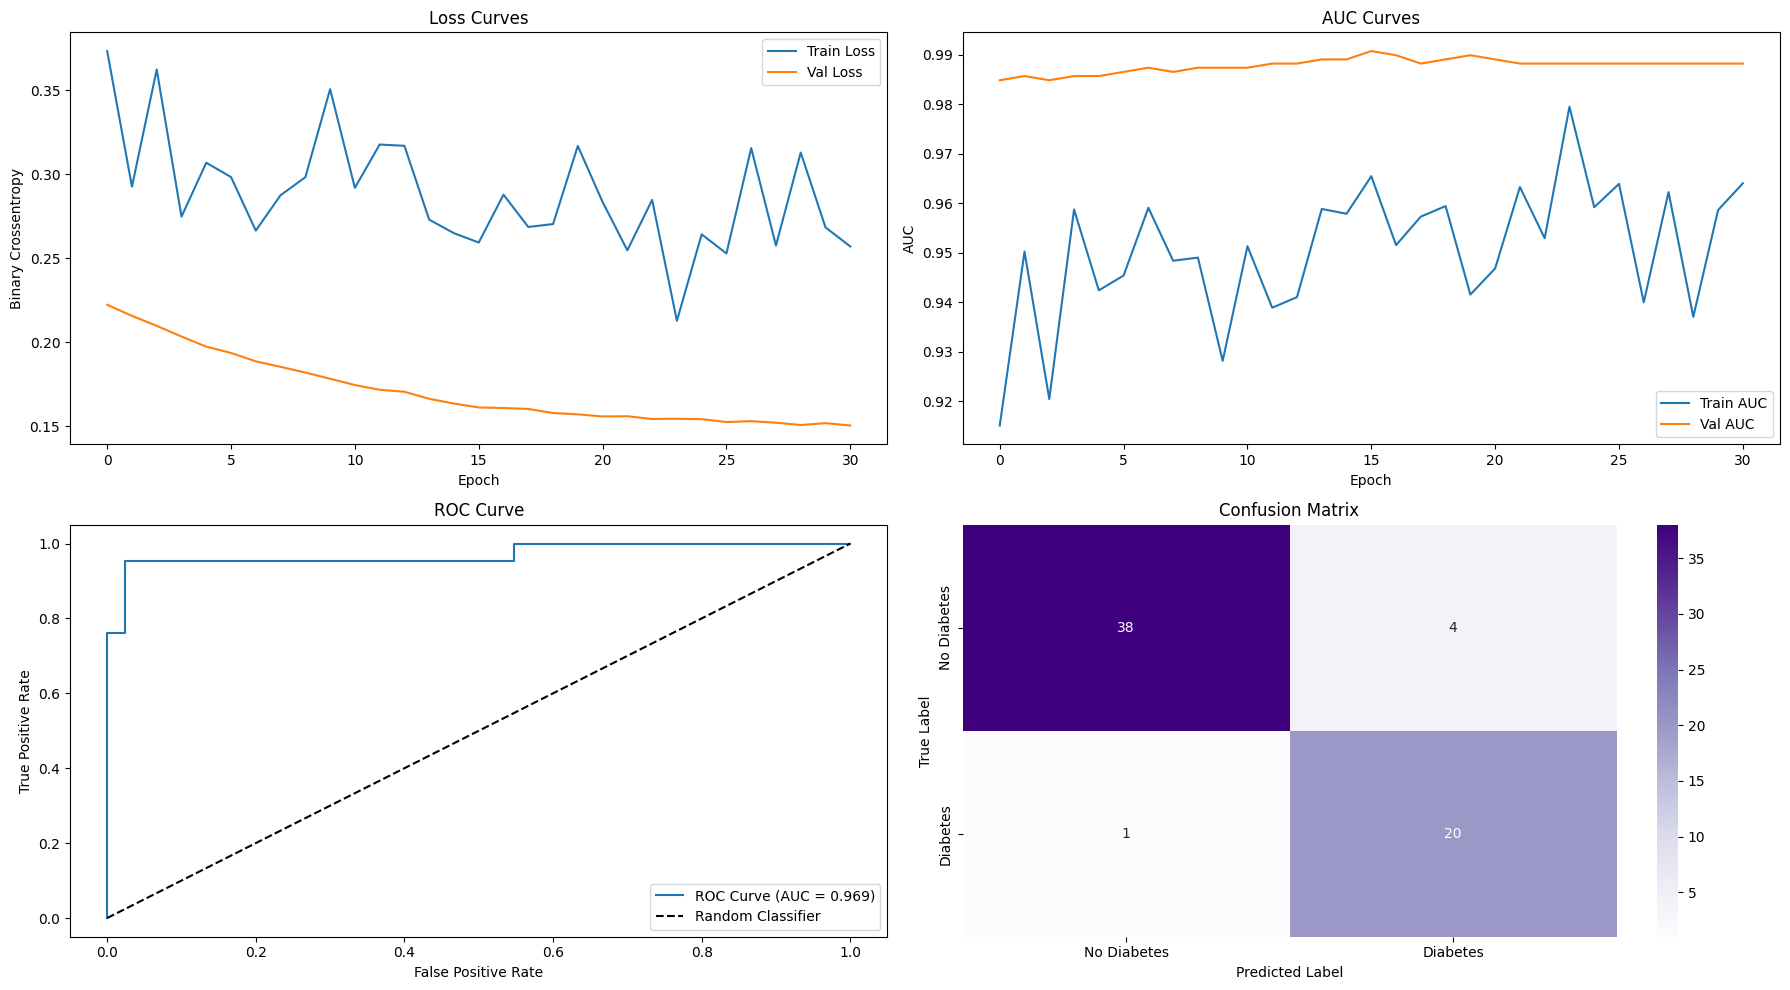

In [ ]:
# Visualizations

plt.figure(figsize=(18, 10))

# 1. Training curves
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC Curves')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# 2. ROC curve
plt.subplot(2, 2, 3)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# 3. Confusion matrix heatmap
plt.subplot(2, 2, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()


In [ ]:
# Save the trained model and artifacts

model_path = "/Users/91life/Desktop/diabetes-project/models/"
os.makedirs(model_path, exist_ok=True)

# Save Keras model in native format
model.save(f"{model_path}ann_model.keras")

# Save scaler
joblib.dump(scaler, f"{model_path}scaler_ann.pkl")
